In [1]:
from IPython.display import Image, display

import graphviz
from typing import Literal
import random
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import List, Optional
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

True

![framework](./resources/stand-alone%20multi%20agent%20framework_v2.png)

In [2]:
class iAgent:
    """
    simple demo
    """
    def __init__(self,name: str,description: str):
        self.name = name
        self.description = description
        self.client = OpenAI()

    def chat(self, messages: list|str):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
            )
        return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]

In [3]:
@dataclass
class AgentSchema:
    """
    This class defines the schema of the agent used for the handoff process.
    """
    name: str
    transfer_to_me_description: str
    agent: iAgent
    relations: Optional[List[str]] = None # agent names that this agent can transfer to
    as_entry: Optional[bool] = False
    as_exit: Optional[bool] = False


In [4]:
class Group:
    def __init__(self, 
                 participants: list[AgentSchema], 
                 model_client: OpenAI = OpenAI()
                 ):
        """ 
        Initializes the group with the given participants and model client.

        Args:
            participants (list[AgentSchema]): A list of AgentSchema objects representing the participants in the group.
            model_client (OpenAI, optional): The OpenAI client used for the handoff process. Defaults to OpenAI().

        Raises:
            ValueError: If the group structure is not valid.
        """
        self.participants = participants
        self.model_client = model_client
        self.entry_agent = next((p for p in participants if p.as_entry), random.choice(participants))
        self.current_agent = self.entry_agent
        self.exit_agent = next((p for p in participants if p.as_exit), None)
        self.agent_map = {p.name: p for p in participants}
        self.handoff_tools = []
        self.participants_order_map = self._build_participant_order_map()
        self.group_structure = self._decide_group_structure()

    def reset(self):
        """
        Resets the state of the framework by setting the current agent to the first participant
        that has the 'as_entry' attribute set to True.
        """
        self.entry_agent = next((p for p in self.participants if p.as_entry), random.choice(self.participants))
        self.current_agent = self.entry_agent


    def handoff_one_turn(self, 
                         messages: list|str,
                         model:str="gpt-4o-mini",
                         next_speaker_select_mode:Literal["order","auto","random"]="auto",
                         include_current:bool = True,
                         verbose=False
                         ):
        """ 
        Performs a single turn of the handoff process.

        Args:
            messages (list|str): The messages to be used for the handoff process.
            model (str, optional): The model used for the handoff process. Defaults to "gpt-4o-mini".
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.
            verbose (bool, optional): Whether to print the handoff process. Defaults to False.
        """

        if next_speaker_select_mode == "order":
            if self.group_structure != "CONNECTED":
                raise ValueError("next_speaker_select_mode 'order' is only supported when group_structure is 'CONNECTED'")
            next_agent = self.participants_order_map[self.current_agent.name]
            if verbose:
                print(f"\n-> handoff from {self.current_agent.name} to {next_agent} (order mode)")
            self.current_agent = self.agent_map[next_agent]
            return next_agent
        
        elif next_speaker_select_mode == "random":
            next_agent = random.choice(self.agent_names)
            if verbose:
                print(f"\n-> handoff from {self.current_agent.name} to {next_agent} (random mode)")
            self.current_agent = self.agent_map[next_agent]
            return next_agent
 
        elif next_speaker_select_mode == "auto":
            
            self._build_current_handoff_tools(include_current=include_current)
    
            if isinstance(messages, str):
                messages = [{"role": "user", "content": messages}]
            messages = [{"role": "system", "content":"deciding which agent to transfer to"}] + messages

            response = self.model_client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=self.handoff_tools,
                        tool_choice="required"
                    )
            next_agent = response.choices[0].message.tool_calls[0].function.name

            if next_agent in self.agent_names:
                if self.current_agent.name != next_agent and verbose:
                    print("\n-> handoff from {} to {} (auto mode)".format(self.current_agent.name, next_agent))
                self.current_agent = self.agent_map[next_agent]
            else:
                raise ValueError(f"Handoff to unknown agent: {next_agent}")

            return next_agent
    
        else:
            raise ValueError(f"Unknown next_speaker_select_mode: {next_speaker_select_mode} , Currently only 'order', 'random' and 'auto' are supported")

    def handoff(self, 
                messages: list|str,
                model:str="gpt-4o-mini",
                handoff_max_turns:int=10,
                next_speaker_select_mode:Literal["order","auto","random"]="auto",
                include_current = True,
                verbose=False
                ):

        """ 
        Performs the handoff process.

        Args:
            messages (list|str): The messages to be used for the handoff process.
            model (str, optional): The model used for the handoff process. Defaults to "gpt-4o-mini".
            handoff_max_turns (int, optional): The maximum number of turns to perform the handoff process. used in auto mode. Defaults to 10.
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.
            verbose (bool, optional): Whether to print the handoff process. Defaults to False.
        """

        next_agent = self.handoff_one_turn(messages,model,next_speaker_select_mode,include_current,verbose)
        if next_speaker_select_mode != "auto" or handoff_max_turns == 1:
            return next_agent
        next_next_agent =  self.handoff_one_turn(messages,model,"auto",include_current,verbose)
        while next_next_agent != next_agent and handoff_max_turns > 1:
            next_agent = next_next_agent
            next_next_agent = self.handoff_one_turn(messages,model,"auto",include_current,verbose)
            handoff_max_turns -= 1
        return next_agent


    def chat(self, 
             messages: list|str,
             model:str="gpt-4o-mini",
             next_speaker_select_mode:Literal["auto","random"]="auto",
             entry_agent:str=None,
             verbose=False
             ):
        
        """ 
        Performs a chat conversation with the group.

        Args:
            messages (list|str): The messages to be used for the chat conversation.
            model (str, optional): The model used for the chat conversation. Defaults to "gpt-4o-mini".
            next_speaker_select_mode (Literal["auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            entry_agent (str, optional): The name of the agent to start the conversation. Defaults to None. You can set it to overwirte the current agent
            verbose (bool, optional): Whether to print the chat conversation. Defaults to False.

        Returns:
            list: A list of messages exchanged during the chat conversation.
        """

        if self.group_structure not in ["CONNECTED","CUSTOM"]:
            raise ValueError("chat is only supported when group_structure is 'CONNECTED' or 'CUSTOM'")
        
        if entry_agent and entry_agent in self.agent_names:
            self.current_agent = self.agent_map[entry_agent]
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        next_agent = self.handoff(messages,model,10,next_speaker_select_mode,True,verbose)

        response = self.agent_map[next_agent].agent.chat(messages)
        if verbose:
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")

        return response


    def task(self,
             task:str,
             model:str="gpt-4o-mini",
             verbose=False
            ):
        
        """ 
        Performs a task with the group.(Notic: current only support sequential task one by one)

        Args:
            task (str): The task to be performed.
            model (str, optional): The model used for the task. Defaults to "gpt-4o-mini".
            verbose (bool, optional): Whether to print the task. Defaults to False.

        Returns:
            list: A list of messages exchanged during the task.
        """

        if self.group_structure != "SEQUENCE":
            raise ValueError("task is only supported when group_structure is 'SEQUENCE' and SEQUENCE must have both entry and exit agents")

        messages = [{"role": "user", "content": task}]
        next_agent = self.entry_agent.name
        result = []
        while next_agent != self.exit_agent.name:
            response = self.agent_map[next_agent].agent.chat(messages)
            if verbose:
                print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
            result.extend(response)
            messages.extend(response)
            next_agent = self.handoff(messages,model,1,"auto",False,verbose)
            messages.append({"role": "user", "content": "transfer to {} ,based on the previous conversation do you job".format(next_agent)})

        response = self.agent_map[next_agent].agent.chat(messages)
        if verbose:
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
        result.extend(response)

        self.reset()
        return result

    def discussion(self,
                   topic:str,
                   model:str="gpt-4o-mini",
                   max_turns:int=5,
                   next_speaker_select_mode:Literal["order","auto","random"]="order",
                   verbose=False
                   ):
        
        """ 
        Performs a discussion with the group.

        Args:
            topic (str): The topic of the discussion.
            model (str, optional): The model used for the discussion. Defaults to "gpt-4o-mini".
            max_turns (int, optional): The maximum number of turns to perform the discussion. Defaults to 5.
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "order".
            verbose (bool, optional): Whether to print the discussion. Defaults to False.

        Returns:
            list: A list of messages exchanged during the discussion.
        """

        if self.group_structure != "CONNECTED":
            raise ValueError("discussion is only supported when group_structure is 'CONNECTED'")
        content = topic
        messages = [{"role": "user", "content": content}]
        next_agent = self.current_agent.name
        result = []
        while max_turns > 0:
            response = self.agent_map[next_agent].agent.chat(messages)
            if verbose:            
                print(f"\n[{next_agent}] \n\n {response[0]['content']}")
            result.extend(response)
            messages.extend(response)
            next_agent = self.handoff(messages,model,1,next_speaker_select_mode,False,verbose)
            messages.extend([{"role": "user", "content": "transfer to {} ,consider your own previous opinion and the previous speaker's opinion, and then give your own opinion".format(next_agent)}])
            max_turns -= 1
        self.reset()

        return result
            
    @property
    def agent_names(self):
        """
        Returns:
            list: A list of names of all participants.
        """
        return [p.name for p in self.participants]
    
    @property
    def relations(self):
        """
        Returns:
            list: A list of tuples representing the relations between participants.
                Each tuple contains the name of a participant and the name of a related participant.
        """
        relations = [("START", self.entry_agent.name)]
        if self.exit_agent:
            relations.append((self.exit_agent.name, "END"))
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            for i in range(len(self.participants)):
                for j in range(len(self.participants)):
                    if i != j:
                        relations.append((self.participants[i].name, self.participants[j].name))
        else:
            for p in self.participants:
                if hasattr(p, 'relations') and isinstance(p.relations, list):
                    relations.extend((p.name, r) for r in p.relations)
        return relations
    
    @property
    def relation_agents(self):
        """
        Returns:
            dict: A dictionary where the keys are participant names and the values are lists of AgentSchema objects
                representing the related agents.
        """
        if self.group_structure == "CUSTOM" or self.group_structure == "SEQUENCE":
            return {p.name: [self.agent_map[r] for r in p.relations] if p.relations else [] for p in self.participants}
        elif self.group_structure == "CONNECTED":
            return {p.name: [a for a in self.participants if a.name != p.name] for p in self.participants}
    

    def draw_relations(self):
        """ 
        Returns:
            bytes: A PNG image of the graph representing the relations between participants.
        """
        dot = graphviz.Digraph(format='png')
        dot.node("START", "START", shape='rect', color='gray', fontcolor='gray')
        if self.exit_agent:
            dot.node("END", "END", shape='rect', color='gray', fontcolor='gray')
        for p in self.participants:
            dot.node(p.name, p.name, color='orange' if p.name == self.current_agent.name else 'black')
        for r in self.relations:
            dot.edge(r[0], r[1])
        return dot.pipe()

    def _build_current_handoff_tools(self, include_current=True):
        """ 
        Builds the handoff tools based on the current agent and its related agents.

        Args:
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.

        Returns:
            list: A list of handoff tools.
        """
        self.handoff_tools = [self._build_agent_schema(self.current_agent)] if include_current else []
        self.handoff_tools.extend(self._build_agent_schema(r) for r in self.relation_agents[self.current_agent.name])

    @staticmethod
    def _build_agent_schema(agent: AgentSchema):
        """
        Builds the schema for the given agent. 
        """
        return {
            "type": "function",
            "function": {
                "name": agent.name,
                "description": agent.transfer_to_me_description,
                "parameters": {"type": "object", "properties": {}, "required": []}
            }
        }
    
    def _build_participant_order_map(self):
        """
        Builds a map of participants in order.

        Returns:
            dict: A dictionary mapping participant names to the next participant in order.
        """
        return {p.name: self.participants[(i+1) % len(self.participants)].name for i, p in enumerate(self.participants)}
    

    def _decide_group_structure(self):
        """ 
        Decides the group structure based on the participants and their relations.

        Returns:
            str: The group structure.

        Raises:
            ValueError: If the group structure is not valid.
        """
        # if all participants do not have relations, then group_structure is CONNECTED
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            return "CONNECTED"
        # if any participant has relations, and entry and exit agents are defined, and no circular relations, then group_structure is SEQUENCE
        if any(hasattr(p, 'relations') and p.relations for p in self.participants) and self.entry_agent and self.exit_agent:
            if self._is_valid_sequence(self.relations):
                return "SEQUENCE"
            else:
                print("[Warning] You may want to construct a SEQUENCE but now this is an invalid SEQUENCE, A SEUQENCE must have both entry and exit agents and no circular relations, Setting group_structure to CUSTOM temporarily")
        return "CUSTOM"
    
 
    @staticmethod
    def _is_valid_sequence(relations):
        """ 
        Checks if the given relations form a valid sequence.

        Args:
            relations (list): A list of tuples representing the relations between participants.

        Returns:
            bool: True if the relations form a valid sequence, False otherwise.
        """
        # Build the graph
        graph = defaultdict(list)
        reverse_graph = defaultdict(list)
        nodes = set()
        for u, v in relations:
            graph[u].append(v)
            reverse_graph[v].append(u)
            nodes.update([u, v])

        # Check for cycles using DFS
        def has_cycle(v, visited, rec_stack):
            visited.add(v)
            rec_stack.add(v)
            for neighbor in graph[v]:
                if neighbor not in visited:
                    if has_cycle(neighbor, visited, rec_stack):
                        return True
                elif neighbor in rec_stack:
                    return True
            rec_stack.remove(v)
            return False

        visited = set()
        rec_stack = set()
        for node in list(graph.keys()):  # Iterate over a list of the dictionary keys
            if node not in visited:
                if has_cycle(node, visited, rec_stack):
                    print("[SEQUENCE INVALID] Cycle detected")
                    return False

        # Check if all nodes are reachable from 'START'
        def bfs_reachable_from_start(start):
            queue = deque([start])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(graph[node])
            return visited

        # Check if all nodes can reach 'END'
        def bfs_reachable_to_end(end):
            queue = deque([end])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(reverse_graph[node])
            return visited

        reachable_from_start = bfs_reachable_from_start('START')
        reachable_to_end = bfs_reachable_to_end('END')

        if nodes != reachable_from_start:
            missing_nodes = nodes - reachable_from_start
            print(f"[SEQUENCE INVALID] Nodes not reachable from START: {missing_nodes}")
            return False

        if nodes != reachable_to_end:
            missing_nodes = nodes - reachable_to_end
            print(f"[SEQUENCE INVALID] Nodes not reachable to END: {missing_nodes}")
            return False

        return True

## CONNNECTED STRUCTURE

Group Structure:  CONNECTED


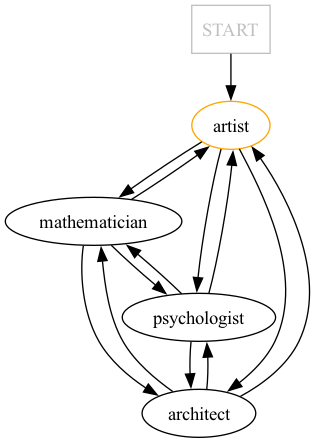

In [5]:
mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")
psychologist = iAgent(name="psychologist", description="You are a psychologist,reply use daily language")

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,)

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist)

psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology.",
                            agent=psychologist)

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect)

g = Group(participants=[mathematician_schema, artist_schema, architect_schema, psychologist_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))

In [6]:
res = g.discussion("what is beauty",next_speaker_select_mode="order",max_turns=5,verbose=True)


[artist] 

 Beauty is such a subjective thing! It's really all about perspective and personal feeling. For some, beauty might be found in nature—a stunning sunset or a blooming flower. For others, it could be in art, music, or even in the way someone carries themselves. It can spark joy, make you feel connected, or even inspire deep emotions. At its core, beauty often reflects harmony, uniqueness, and the experiences that resonate with us. What do you think is beautiful?

-> handoff from artist to architect (order mode)

[architect] 

 As an architect, I see beauty as a blend of aesthetics, functionality, and context. It's not just about how a structure looks; it's also about how it feels and how it fits into its surroundings. A beautiful building can evoke emotions, create connections, and enhance the experience of the people who interact with it.

I think beauty in architecture emerges from thoughtful design that respects both the environment and the needs of the people using the sp

### CUSTOM STRUCTURE

Group Structure:  CUSTOM


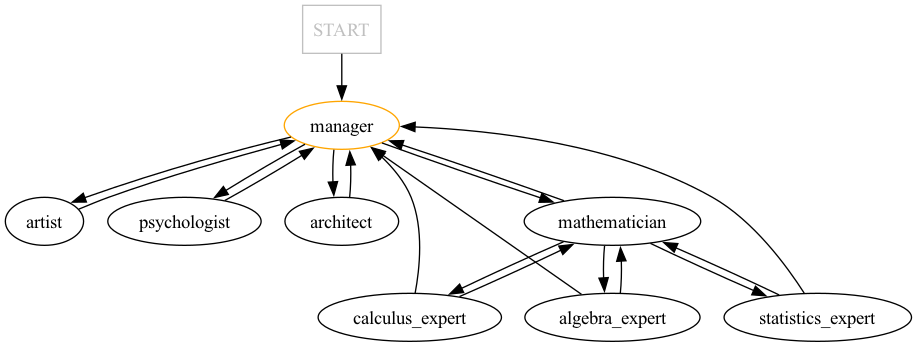

In [7]:
manager = iAgent(name="manager", description="You are a manager,determine which agent to transfer to")

mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")
psychologist = iAgent(name="psychologist", description="You are a psychologist,reply use daily language")

calculus_expert = iAgent(name="calculus_expert", description="You are a calculus expert,reply use daily language")
algebra_expert = iAgent(name="algebra_expert", description="You are an algebra expert,reply use daily language")
statistics_expert = iAgent(name="statistics_expert", description="You are a statistics expert,reply use daily language")

manager_schema = AgentSchema(name="manager",
                            transfer_to_me_description="Call me if you do not know which agent to transfer to.",
                            agent=manager,
                            relations=["mathematician", "artist", "psychologist", "architect"],
                            as_entry=True)

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist,
                            relations=["manager"])

psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology.",
                            agent=psychologist,
                            relations=["manager"])

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect,
                            relations=["manager"])

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,
                            relations=["calculus_expert", "algebra_expert", "statistics_expert","manager"])

calculus_expert_schema = AgentSchema(name="calculus_expert",
                            transfer_to_me_description="Call me if you have any questions about calculus.",
                            agent=calculus_expert,
                            relations=["mathematician","manager"])

algebra_expert_schema = AgentSchema(name="algebra_expert",
                            transfer_to_me_description="Call me if you have any questions about algebra.",
                            agent=algebra_expert,
                            relations=["mathematician","manager"])

statistics_expert_schema = AgentSchema(name="statistics_expert",
                            transfer_to_me_description="Call me if you have any questions about statistics.",
                            agent=statistics_expert,
                            relations=["mathematician","manager"])


g = Group(participants=[manager_schema, 
                        artist_schema, psychologist_schema, architect_schema, mathematician_schema, 
                        calculus_expert_schema, algebra_expert_schema, statistics_expert_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))


-> handoff from manager to mathematician (auto mode)

-> handoff from mathematician to statistics_expert (auto mode)


[statistics_expert] 

 Sure! Statistics is all about collecting, analyzing, interpreting, and presenting data. Think of it as a way to make sense of numbers and information we gather from the world around us.

1. **Collecting Data**: This is the first step where you gather information. For example, if you're interested in how many pets people have, you might conduct a survey or use existing data.

2. **Analyzing Data**: Once you have the data, you look for patterns or trends. This might involve calculations like averages (mean), medians, or percentages.

3. **Interpreting Data**: This is about making sense of what you found. For instance, if you discovered that most people have two pets, you might conclude that owning pets is quite common.

4. **Presenting Data**: Finally, you share your findings. This could be through charts, graphs, or reports to make the informatio

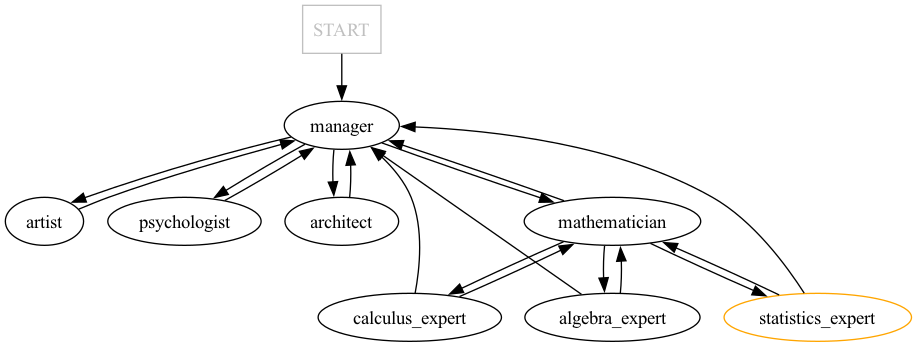

In [8]:
response = g.chat("expalin the concept of statistics",verbose=True)
display(Image(g.draw_relations()))


-> handoff from statistics_expert to manager (auto mode)

-> handoff from manager to psychologist (auto mode)


[psychologist] 

 I’m sorry to hear that you’re feeling this way. It's okay to feel sad sometimes; it's a normal part of being human. Do you want to talk about what's been on your mind? Sometimes sharing what you're going through can help a lot.


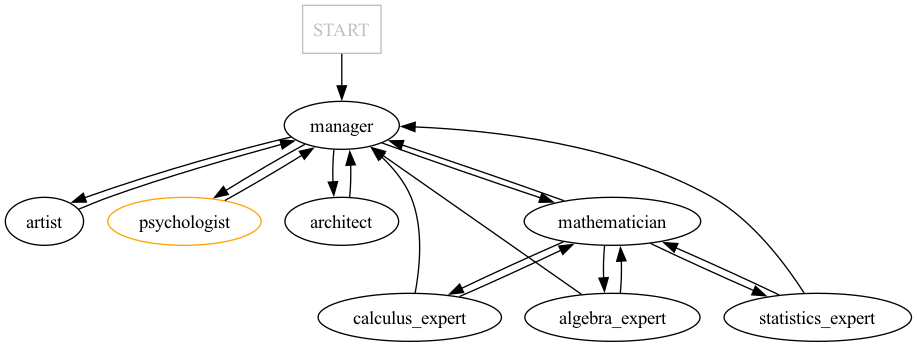

In [9]:
response =  g.chat("I feel sad",verbose=True)
display(Image(g.draw_relations()))

### SEQUENCE STRUCTURE

Group Structure:  SEQUENCE


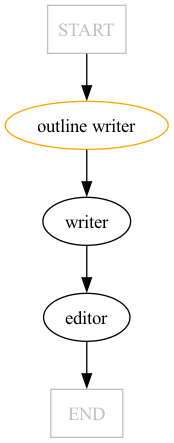

In [10]:
outline_agent = iAgent(name="outline writer", description="You are an outline writer who are good at organizing ideas")
writer = iAgent(name="writer", description="You are a writer who are good at writing drafts")
editor = iAgent(name="editor", description="You are an editor who are good at editing articles and making them more readable")

outline_writer_schema = AgentSchema(name="outline writer",
                                    transfer_to_me_description="Call me if you need help organizing your ideas.",
                                    agent=outline_agent,
                                    relations=["writer"],
                                    as_entry=True)

writer_schema = AgentSchema(name="writer",
                            transfer_to_me_description="Call me if you need help writing articles.",
                            agent=writer,
                            relations=["editor"])

editor_schema = AgentSchema(name="editor",
                            transfer_to_me_description="Call me if you need help editing articles.",
                            agent=editor,
                            as_exit=True)


g = Group(participants=[outline_writer_schema, writer_schema, editor_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))

In [11]:
res = g.task("write a article about the importance of reading books",verbose=True)



[outline writer] 

 # The Importance of Reading Books

## Introduction
- Brief overview of reading as a fundamental human activity.
- Statistics on reading habits globally.
- Thesis statement: Reading books is crucial for personal growth, mental well-being, and fostering a connected society.

## I. Cognitive Benefits of Reading
### A. Enhances Vocabulary and Language Skills
- Exposure to diverse vocabulary and sentence structures.
- Influence on writing abilities and communication.

### B. Improves Memory and Concentration
- Discussion on how reading strengthens the brain.
- Evidence of improved focus and retention.

### C. Encourages Critical Thinking
- Analysis of different viewpoints in literature.
- Development of analytical skills through engagement with complex narratives.

## II. Emotional and Psychological Benefits
### A. Reduces Stress and Promotes Relaxation
- Connection between reading and lowered cortisol levels.
- Comparison of reading with other relaxation methods.

###